In [2]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# REINFORCE

In [5]:
# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [6]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [7]:
#All available environments
#print(gym.envs.registry.all()) 

episode: 0, total reward: 13.0, average_reward: 13.0, length: 12
episode: 1, total reward: 27.0, average_reward: 20.0, length: 26
episode: 2, total reward: 66.0, average_reward: 35.333, length: 65
episode: 3, total reward: 16.0, average_reward: 30.5, length: 15
episode: 4, total reward: 28.0, average_reward: 30.0, length: 27
episode: 5, total reward: 11.0, average_reward: 26.833, length: 10
episode: 6, total reward: 13.0, average_reward: 24.857, length: 12
episode: 7, total reward: 51.0, average_reward: 28.125, length: 50
episode: 8, total reward: 24.0, average_reward: 27.667, length: 23
episode: 9, total reward: 15.0, average_reward: 26.4, length: 14
episode: 10, total reward: 20.0, average_reward: 27.1, length: 19
episode: 11, total reward: 36.0, average_reward: 28.0, length: 35
episode: 12, total reward: 16.0, average_reward: 23.0, length: 15
episode: 13, total reward: 12.0, average_reward: 22.6, length: 11
episode: 14, total reward: 11.0, average_reward: 20.9, length: 10
episode: 1

episode: 124, total reward: 19.0, average_reward: 24.1, length: 18
episode: 125, total reward: 21.0, average_reward: 25.1, length: 20
episode: 126, total reward: 23.0, average_reward: 25.1, length: 22
episode: 127, total reward: 21.0, average_reward: 24.2, length: 20
episode: 128, total reward: 19.0, average_reward: 23.2, length: 18
episode: 129, total reward: 19.0, average_reward: 23.9, length: 18
episode: 130, total reward: 43.0, average_reward: 25.7, length: 42
episode: 131, total reward: 10.0, average_reward: 21.2, length: 9
episode: 132, total reward: 49.0, average_reward: 24.4, length: 48
episode: 133, total reward: 15.0, average_reward: 23.9, length: 14
episode: 134, total reward: 11.0, average_reward: 23.1, length: 10
episode: 135, total reward: 33.0, average_reward: 24.3, length: 32
episode: 136, total reward: 27.0, average_reward: 24.7, length: 26
episode: 137, total reward: 27.0, average_reward: 25.3, length: 26
episode: 138, total reward: 34.0, average_reward: 26.8, length:

episode: 247, total reward: 38.0, average_reward: 31.2, length: 37
episode: 248, total reward: 12.0, average_reward: 30.3, length: 11
episode: 249, total reward: 33.0, average_reward: 30.2, length: 32
episode: 250, total reward: 24.0, average_reward: 31.5, length: 23
episode: 251, total reward: 31.0, average_reward: 30.4, length: 30
episode: 252, total reward: 9.0, average_reward: 29.3, length: 8
episode: 253, total reward: 39.0, average_reward: 31.6, length: 38
episode: 254, total reward: 60.0, average_reward: 36.3, length: 59
episode: 255, total reward: 26.0, average_reward: 35.4, length: 25
episode: 256, total reward: 109.0, average_reward: 38.1, length: 108
episode: 257, total reward: 22.0, average_reward: 36.5, length: 21
episode: 258, total reward: 28.0, average_reward: 38.1, length: 27
episode: 259, total reward: 21.0, average_reward: 36.9, length: 20
episode: 260, total reward: 38.0, average_reward: 38.3, length: 37
episode: 261, total reward: 11.0, average_reward: 36.3, length

episode: 370, total reward: 13.0, average_reward: 29.8, length: 12
episode: 371, total reward: 33.0, average_reward: 30.9, length: 32
episode: 372, total reward: 26.0, average_reward: 32.2, length: 25
episode: 373, total reward: 18.0, average_reward: 30.7, length: 17
episode: 374, total reward: 17.0, average_reward: 29.6, length: 16
episode: 375, total reward: 17.0, average_reward: 24.3, length: 16
episode: 376, total reward: 20.0, average_reward: 25.1, length: 19
episode: 377, total reward: 24.0, average_reward: 23.1, length: 23
episode: 378, total reward: 29.0, average_reward: 23.2, length: 28
episode: 379, total reward: 67.0, average_reward: 26.4, length: 66
episode: 380, total reward: 82.0, average_reward: 33.3, length: 81
episode: 381, total reward: 29.0, average_reward: 32.9, length: 28
episode: 382, total reward: 27.0, average_reward: 33.0, length: 26
episode: 383, total reward: 35.0, average_reward: 34.7, length: 34
episode: 384, total reward: 34.0, average_reward: 36.4, length

episode: 493, total reward: 37.0, average_reward: 50.3, length: 36
episode: 494, total reward: 57.0, average_reward: 53.8, length: 56
episode: 495, total reward: 88.0, average_reward: 58.6, length: 87
episode: 496, total reward: 15.0, average_reward: 56.6, length: 14
episode: 497, total reward: 18.0, average_reward: 54.0, length: 17
episode: 498, total reward: 19.0, average_reward: 48.5, length: 18
episode: 499, total reward: 35.0, average_reward: 47.7, length: 34
episode: 500, total reward: 71.0, average_reward: 45.1, length: 70
episode: 501, total reward: 37.0, average_reward: 44.2, length: 36
episode: 502, total reward: 100.0, average_reward: 47.7, length: 99
episode: 503, total reward: 45.0, average_reward: 48.5, length: 44
episode: 504, total reward: 17.0, average_reward: 44.5, length: 16
episode: 505, total reward: 45.0, average_reward: 40.2, length: 44
episode: 506, total reward: 33.0, average_reward: 42.0, length: 32
episode: 507, total reward: 46.0, average_reward: 44.8, lengt

episode: 615, total reward: 103.0, average_reward: 83.3, length: 102
episode: 616, total reward: 57.0, average_reward: 70.2, length: 56
episode: 617, total reward: 52.0, average_reward: 72.5, length: 51
episode: 618, total reward: 124.0, average_reward: 71.3, length: 123
episode: 619, total reward: 155.0, average_reward: 82.0, length: 154
episode: 620, total reward: 51.0, average_reward: 84.8, length: 50
episode: 621, total reward: 183.0, average_reward: 90.7, length: 182
episode: 622, total reward: 134.0, average_reward: 98.1, length: 133
episode: 623, total reward: 62.0, average_reward: 93.6, length: 61
episode: 624, total reward: 200.0, average_reward: 112.1, length: 199
episode: 625, total reward: 91.0, average_reward: 110.9, length: 90
episode: 626, total reward: 34.0, average_reward: 108.6, length: 33
episode: 627, total reward: 85.0, average_reward: 111.9, length: 84
episode: 628, total reward: 33.0, average_reward: 102.8, length: 32
episode: 629, total reward: 48.0, average_rew

episode: 735, total reward: 34.0, average_reward: 98.6, length: 33
episode: 736, total reward: 68.0, average_reward: 96.1, length: 67
episode: 737, total reward: 100.0, average_reward: 92.4, length: 99
episode: 738, total reward: 124.0, average_reward: 97.3, length: 123
episode: 739, total reward: 173.0, average_reward: 110.8, length: 172
episode: 740, total reward: 125.0, average_reward: 108.2, length: 124
episode: 741, total reward: 153.0, average_reward: 116.3, length: 152
episode: 742, total reward: 200.0, average_reward: 119.4, length: 199
episode: 743, total reward: 84.0, average_reward: 118.8, length: 83
episode: 744, total reward: 106.0, average_reward: 116.7, length: 105
episode: 745, total reward: 113.0, average_reward: 124.6, length: 112
episode: 746, total reward: 77.0, average_reward: 125.5, length: 76
episode: 747, total reward: 44.0, average_reward: 119.9, length: 43
episode: 748, total reward: 188.0, average_reward: 126.3, length: 187
episode: 749, total reward: 200.0, 

episode: 854, total reward: 173.0, average_reward: 162.3, length: 172
episode: 855, total reward: 200.0, average_reward: 170.3, length: 199
episode: 856, total reward: 200.0, average_reward: 172.4, length: 199
episode: 857, total reward: 140.0, average_reward: 172.7, length: 139
episode: 858, total reward: 200.0, average_reward: 172.7, length: 199
episode: 859, total reward: 155.0, average_reward: 170.0, length: 154
episode: 860, total reward: 135.0, average_reward: 163.5, length: 134
episode: 861, total reward: 200.0, average_reward: 171.2, length: 199
episode: 862, total reward: 200.0, average_reward: 177.1, length: 199
episode: 863, total reward: 124.0, average_reward: 172.7, length: 123
episode: 864, total reward: 170.0, average_reward: 172.4, length: 169
episode: 865, total reward: 200.0, average_reward: 172.4, length: 199
episode: 866, total reward: 200.0, average_reward: 172.4, length: 199
episode: 867, total reward: 178.0, average_reward: 176.2, length: 177
episode: 868, total 

episode: 972, total reward: 150.0, average_reward: 167.3, length: 149
episode: 973, total reward: 199.0, average_reward: 169.4, length: 198
episode: 974, total reward: 200.0, average_reward: 175.0, length: 199
episode: 975, total reward: 87.0, average_reward: 167.2, length: 86
episode: 976, total reward: 182.0, average_reward: 165.4, length: 181
episode: 977, total reward: 155.0, average_reward: 172.2, length: 154
episode: 978, total reward: 200.0, average_reward: 172.2, length: 199
episode: 979, total reward: 200.0, average_reward: 177.3, length: 199
episode: 980, total reward: 161.0, average_reward: 173.4, length: 160
episode: 981, total reward: 126.0, average_reward: 166.0, length: 125
episode: 982, total reward: 136.0, average_reward: 164.6, length: 135
episode: 983, total reward: 182.0, average_reward: 162.9, length: 181
episode: 984, total reward: 173.0, average_reward: 160.2, length: 172
episode: 985, total reward: 200.0, average_reward: 171.5, length: 199
episode: 986, total re

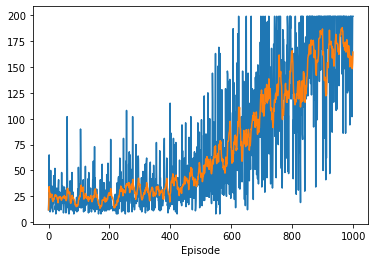

3934.6498839999995


In [8]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
max_episode_num = 1000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
            
        state = new_state
        
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()
print(np.var(numsteps))